## Time Series Forecasting For Energy Consumption using Pandas and sklearn

In [46]:
import pandas as pd
import sklearn
import sklearn.metrics as metrics
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import numpy as np



In [18]:
url='https://raw.githubusercontent.com/jenfly/opsd/master/opsd_germany_daily.csv'
data = pd.read_csv(url,sep=",")

In [19]:
data.head

<bound method NDFrame.head of             Date  Consumption     Wind   Solar  Wind+Solar
0     2006-01-01   1069.18400      NaN     NaN         NaN
1     2006-01-02   1380.52100      NaN     NaN         NaN
2     2006-01-03   1442.53300      NaN     NaN         NaN
3     2006-01-04   1457.21700      NaN     NaN         NaN
4     2006-01-05   1477.13100      NaN     NaN         NaN
...          ...          ...      ...     ...         ...
4378  2017-12-27   1263.94091  394.507  16.530     411.037
4379  2017-12-28   1299.86398  506.424  14.162     520.586
4380  2017-12-29   1295.08753  584.277  29.854     614.131
4381  2017-12-30   1215.44897  721.247   7.467     728.714
4382  2017-12-31   1107.11488  721.176  19.980     741.156

[4383 rows x 5 columns]>

In [20]:
data.dtypes

Date            object
Consumption    float64
Wind           float64
Solar          float64
Wind+Solar     float64
dtype: object

## Lets change the type of Date Column to datatime format

In [21]:
data['Date']=pd.to_datetime(data['Date'])
#data[0:5]
data=data.set_index('Date')
data.head

<bound method NDFrame.head of             Consumption     Wind   Solar  Wind+Solar
Date                                                
2006-01-01   1069.18400      NaN     NaN         NaN
2006-01-02   1380.52100      NaN     NaN         NaN
2006-01-03   1442.53300      NaN     NaN         NaN
2006-01-04   1457.21700      NaN     NaN         NaN
2006-01-05   1477.13100      NaN     NaN         NaN
...                 ...      ...     ...         ...
2017-12-27   1263.94091  394.507  16.530     411.037
2017-12-28   1299.86398  506.424  14.162     520.586
2017-12-29   1295.08753  584.277  29.854     614.131
2017-12-30   1215.44897  721.247   7.467     728.714
2017-12-31   1107.11488  721.176  19.980     741.156

[4383 rows x 4 columns]>

# Modeling
Our Aim is to predict the power consumption for this time series data for coming unseen dates. We will be using 2006-2016 data for training and 2017 data for testing. In order to evaluate how good our model is, we would be using R-squared and Root Mean Squared Error (but will be printing all relevant metrics for you to take the final call).

In [22]:
def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

# Feature Engineeringfor time series

In [23]:
data_consumption=data[['Consumption']]

In [24]:
data_consumption.loc[:,'Yesterday']=data_consumption.loc[:,'Consumption'].shift()#   dataframe.loc[:,'Column_name'], Ist value indicates the row index value(id : used it means all indexes, 2nd value shows column)
data_consumption.head

C:\Users\zohai\anaconda3\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\zohai\anaconda3\lib\site-packages\pandas\core\indexing.py:1047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


<bound method NDFrame.head of             Consumption   Yesterday
Date                               
2006-01-01   1069.18400         NaN
2006-01-02   1380.52100  1069.18400
2006-01-03   1442.53300  1380.52100
2006-01-04   1457.21700  1442.53300
2006-01-05   1477.13100  1457.21700
...                 ...         ...
2017-12-27   1263.94091  1130.11683
2017-12-28   1299.86398  1263.94091
2017-12-29   1295.08753  1299.86398
2017-12-30   1215.44897  1295.08753
2017-12-31   1107.11488  1215.44897

[4383 rows x 2 columns]>

In [25]:
# inserting another column with difference between yesterday and day before yesterday's consumption values.
data_consumption.loc[:,'Yesterday_Diff'] = data_consumption.loc[:,'Yesterday'].diff()
data_consumption[0:10]

C:\Users\zohai\anaconda3\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\zohai\anaconda3\lib\site-packages\pandas\core\indexing.py:1047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


,Consumption,Yesterday,Yesterday_Diff
Date,,,
2006-01-01,1069.184,NaN,NaN
2006-01-02,1380.521,1069.184,NaN
2006-01-03,1442.533,1380.521,311.337
2006-01-04,1457.217,1442.533,62.012
2006-01-05,1477.131,1457.217,14.684
2006-01-06,1403.427,1477.131,19.914
2006-01-07,1300.287,1403.427,-73.704
2006-01-08,1207.985,1300.287,-103.140
2006-01-09,1529.323,1207.985,-92.302


## Droping Null values

In [26]:
# dropping NAs
data_consumption = data_consumption.dropna()

In [27]:
data_consumption['2016']

,Consumption,Yesterday,Yesterday_Diff
Date,,,
2016-01-01,1060.366,1158.103,-80.760
2016-01-02,1192.698,1060.366,-97.737
2016-01-03,1179.282,1192.698,132.332
2016-01-04,1456.294,1179.282,-13.416
2016-01-05,1506.737,1456.294,277.012
...,...,...,...
2016-12-27,1289.324,1121.213,3.540
2016-12-28,1294.881,1289.324,168.111
2016-12-29,1295.897,1294.881,5.557


## Define Training and Test Datasets
Setting 2006-2016 as Training data
Seeting 2017 as Test Data

In [28]:
X_train=data_consumption[:'2016'].drop('Consumption', axis=1)
y_train=data_consumption.loc[:'2016', 'Consumption']

In [29]:
X_test=data_consumption['2017'].drop('Consumption', axis=1)
y_test=data_consumption.loc['2017','Consumption']

## Cross-Validation for time series data
Since time serties data has natural ordering, means every instance can be related to previous instance with some relation. Therefor random splitting for cross validation like in K-fold will break the dependence among the instances. Therefore we use another cross validation technique called Forward chaining for time series data.

sklearn has a provision for implementing such train test split using TimeSeriesSplit.
The TimeSerieSplit function takes as input the number of splits. Since our training data has 11 unique years (2006 -2016), we would be setting n_splits = 10. This way we have neat training and validation sets:

fold 1: training [2006], validation [2007]

fold 2: training [2006 2007], validation [2008]

fold 3: training [2006 2007 2008], validation [2009]

fold 4: training [2006 2007 2008 2009], validation [2010]

fold 5: training [2006 2007 2008 2009 2010], validation [2011]

fold 6: training [2006 2007 2008 2009 2010 2011], validation [2012]

fold 7: training [2006 2007 2008 2009 2010 2011 2012], validation [2013]

fold 8: training [2006 2007 2008 2009 2010 2011 2012 2013], validation [2014]

fold 9: training [2006 2007 2008 2009 2010 2011 2012 2013 2014], validation [2015]

fold 10: training [2006 2007 2008 2009 2010 2011 2012 2013 2014 2015], validation [2016]

## Algorithms

In [30]:
models = []
models.append(('LR', LinearRegression()))
models.append(('KNN', KNeighborsRegressor())) 
models.append(('RF', RandomForestRegressor(n_estimators = 10))) # Ensemble method - collection of many decision trees
models.append(('SVR', SVR(gamma='auto'))) # kernel = linear
# Evaluate each model in turn
results = []
names = []
for name, model in models:
    # TimeSeries Cross validation
    tscv = TimeSeriesSplit(n_splits=10)
    
    cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    


LR: 0.343747 (0.029773)
KNN: 0.646307 (0.083185)
RF: 0.614037 (0.079610)
SVR: -0.117944 (0.157755)


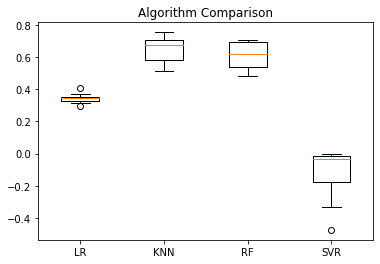

In [31]:
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

Both KNN and RF perform equally well. But I personally prefer RF since this ensemble model (combine multiple ‘individual’ (diverse) models together and deliver superior prediction power.) can almost work out of the box and that is one reason why they are very popular.

## Grid Searching Hyperparameters for Random Forest Regressor
Lets try to tune the hyperparameters of random forest classifier to achhieve better results. 

In [35]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [37]:
tscv = TimeSeriesSplit(n_splits=10)
Random_Reg=RandomForestRegressor()
parameters_grid={'n_estimators':[10,20,45], 'max_features':['auto','log2','sqrt'], 'max_depth': [6,12,14]}
Search=GridSearchCV(estimator=Random_Reg, param_grid=parameters_grid,cv= tscv, scoring = 'r2')
Search.fit(X_train,y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verb

In [43]:
best_score = Search.best_score_
best_model = Search.best_estimator_
print('r2: ', best_score)

r2:  0.6702140263098165


## Checking best model performance on test data

In [47]:
y_true=y_test.values
y_predict=best_model.predict(X_test)
regression_results(y_true, y_predict)

explained_variance:  0.7192
mean_squared_log_error:  0.0043
r2:  0.7174
MAE:  56.5672
MSE:  7653.6979
RMSE:  87.4854


In [49]:
data_consumption.loc[:, 'Yesterday-1']=data_consumption.loc[:, 'Yesterday'].shift()

C:\Users\zohai\anaconda3\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\zohai\anaconda3\lib\site-packages\pandas\core\indexing.py:1047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [50]:
data_consumption

,Consumption,Yesterday,Yesterday_Diff,Yesterday-1
Date,,,,
2006-01-03,1442.53300,1380.52100,311.33700,NaN
2006-01-04,1457.21700,1442.53300,62.01200,1380.52100
2006-01-05,1477.13100,1457.21700,14.68400,1442.53300
2006-01-06,1403.42700,1477.13100,19.91400,1457.21700
2006-01-07,1300.28700,1403.42700,-73.70400,1477.13100
...,...,...,...,...
2017-12-27,1263.94091,1130.11683,18.83345,1111.28338
2017-12-28,1299.86398,1263.94091,133.82408,1130.11683
2017-12-29,1295.08753,1299.86398,35.92307,1263.94091


In [51]:
# inserting column with difference in yesterday-1 and yesterday-2 values.
data_consumption['Yesterday-1_Diff'] = data_consumption['Yesterday-1'].diff()

C:\Users\zohai\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [53]:
# dropping NAs
data_consumption= data_consumption.dropna()

## Resetting the train and test set

In [54]:
X_train= data_consumption[:'2016'].drop(['Consumption'], axis = 1)
y_train= data_consumption.loc[:'2016', 'Consumption']
X_test = data_consumption['2017'].drop(['Consumption'], axis = 1)
y_test = data_consumption.loc['2017', 'Consumption']

## Checking to see if the ‘best’ random forest using ‘new’ predictors performs better

In [55]:
model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = 'r2')
gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
y_true = y_test.values
y_pred = best_model.predict(X_test)
regression_results(y_true, y_pred)

explained_variance:  0.8427
mean_squared_log_error:  0.0024
r2:  0.8427
MAE:  40.3477
MSE:  4259.929
RMSE:  65.2681


## Feature Engineering strikes back
Let us see if adding the value of solar production is beneficial in some way to predicting electricity consumption.

In [56]:
data_consumption_solar = data_consumption.join(data[['Solar']])
data_consumption_solar = data_consumption_solar.dropna()

In [57]:
data_consumption_solar

,Consumption,Yesterday,Yesterday_Diff,Yesterday-1,Yesterday-1_Diff,Solar
Date,,,,,,
2012-01-01,948.12800,1077.62500,-122.24100,1199.86600,-27.02200,6.587
2012-01-02,1269.58100,948.12800,-129.49700,1077.62500,-122.24100,6.574
2012-01-03,1334.74500,1269.58100,321.45300,948.12800,-129.49700,24.679
2012-01-04,1347.13600,1334.74500,65.16400,1269.58100,321.45300,14.681
2012-01-05,1376.65800,1347.13600,12.39100,1334.74500,65.16400,5.071
...,...,...,...,...,...,...
2017-12-27,1263.94091,1130.11683,18.83345,1111.28338,-30.47392,16.530
2017-12-28,1299.86398,1263.94091,133.82408,1130.11683,18.83345,14.162
2017-12-29,1295.08753,1299.86398,35.92307,1263.94091,133.82408,29.854


## Resetting Train/Test + GridSearch + Checking performance

In [60]:
X_train = data_consumption_solar[:'2016'].drop(['Consumption'], axis = 1)
y_train = data_consumption_solar.loc[:'2016', 'Consumption']
X_test = data_consumption_solar['2017'].drop(['Consumption'], axis = 1)
y_test = data_consumption_solar.loc['2017', 'Consumption']
model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = 'r2')
gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
y_true = y_test.values
y_pred = best_model.predict(X_test)
regression_results(y_true, y_pred)

explained_variance:  0.8414
mean_squared_log_error:  0.0025
r2:  0.841
MAE:  39.8362
MSE:  4306.7923
RMSE:  65.6262


# Variable Importance Plot

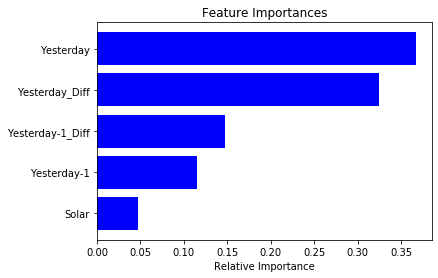

In [62]:
imp = best_model.feature_importances_
features = X_train.columns
indices = np.argsort(imp)
plt.title('Feature Importances')
plt.barh(range(len(indices)), imp[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Feature Engineering Endgame
If you followed the narrative in Part 1 of my previous blog post, you would remember that our dataset has some seasonal element to it, weekly seasonality to be more precise. Thus, it would make more sense to feed as input to the model, consumption value in the week prior to the given date. That means, if the model is trying to predict the consumption value on Jan 8, it must be fed information about the consumption on Jan 1.

In [63]:
data_consumption_solar_weeklyShift = data_consumption_solar.copy()
data_consumption_solar_weeklyShift['Last_Week'] = data_consumption_solar['Consumption'].shift(7)
data_consumption_solar_weeklyShift = data_consumption_solar_weeklyShift.dropna()

In [64]:
data_consumption_solar_weeklyShift

,Consumption,Yesterday,Yesterday_Diff,Yesterday-1,Yesterday-1_Diff,Solar,Last_Week
Date,,,,,,,
2012-01-08,1103.38300,1175.68800,-115.52700,1291.21500,-85.44300,8.440,948.12800
2012-01-09,1443.37100,1103.38300,-72.30500,1175.68800,-115.52700,5.264,1269.58100
2012-01-10,1434.63100,1443.37100,339.98800,1103.38300,-72.30500,17.827,1334.74500
2012-01-11,1449.76800,1434.63100,-8.74000,1443.37100,339.98800,10.849,1347.13600
2012-01-12,1442.44800,1449.76800,15.13700,1434.63100,-8.74000,18.023,1376.65800
...,...,...,...,...,...,...,...
2017-12-27,1263.94091,1130.11683,18.83345,1111.28338,-30.47392,16.530,1559.68569
2017-12-28,1299.86398,1263.94091,133.82408,1130.11683,18.83345,14.162,1520.37206
2017-12-29,1295.08753,1299.86398,35.92307,1263.94091,133.82408,29.854,1423.23782


In [66]:
X_train_solar_weeklyShift = data_consumption_solar_weeklyShift[:'2016'].drop(['Consumption'], axis = 1)
y_train_solar_weeklyShift = data_consumption_solar_weeklyShift.loc[:'2016', 'Consumption']
X_test = data_consumption_solar_weeklyShift['2017'].drop(['Consumption'], axis = 1)
y_test = data_consumption_solar_weeklyShift.loc['2017', 'Consumption']
model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = 'r2')
gsearch.fit(X_train_solar_weeklyShift, y_train_solar_weeklyShift)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
y_true = y_test.values
y_pred = best_model.predict(X_test)
regression_results(y_true, y_pred)

explained_variance:  0.8935
mean_squared_log_error:  0.0017
r2:  0.8931
MAE:  31.7283
MSE:  2895.4932
RMSE:  53.8098


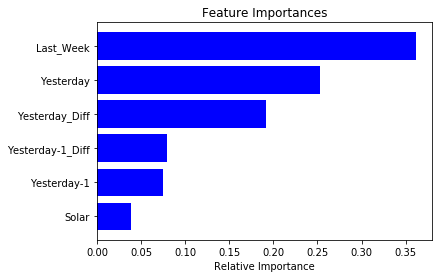

In [69]:
imp = best_model.feature_importances_
features = X_train_solar_weeklyShift.columns
indices = np.argsort(imp)
plt.title('Feature Importances')
plt.barh(range(len(indices)), imp[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Conclusion
In this article, we learned how to model time series data, conduct cross-validation on time series data, and fine-tune our model hyperparameters. We also successfully managed to reduce the RMSE from 85.61 to 54.57 for predicting power consumption.